In [6]:
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

import keras
from keras.layers import GlobalAveragePooling2D , Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import transform

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import os
import csv
import random
import pickle


#----All methods and functions-------------------------------------------------------------------------
#def random_rotate(image, angles = (-15,15)):
    
#    rand_angle = random.randint(angles[0],angles[1])
#    rot = transform.rotate(image,rand_angle,mode='edge')
#    return np.array(rot).reshape(160,320,3)
def random_contrast(image, gamma_range = 0.5):
    
    image = image.astype(np.uint8)
    gamma = random.uniform(gamma_range,1+gamma_range)
    
    invGamma = 1.0 / gamma
    image = cv2.cvtColor(image,cv2.COLOR_YUV2RGB)
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return np.array(cv2.cvtColor(cv2.LUT(image, table),cv2.COLOR_RGB2YUV))
    
def random_shadow(img, w_low=0.2, w_high=0.4):
    
    img = img.astype(np.uint8)
    height, width = (img.shape[0], img.shape[1])
    
    x1_top = np.random.random() * width/2 
    x2_top = np.random.uniform(x1_top,width)
    
    x1_bot = np.random.random() * width
    x2_bot = np.random.uniform(x1_top,width)
    
    poly = np.asarray([[ [x1_top,0], [x1_bot,height], [x2_bot,height], [x2_top,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    
    return np.array(cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0)).astype(np.uint8)

def random_translation(img,translation = (-10,10)):
    
    x = np.random.randint(translation[0],translation[1])
    
    T = np.float32([[1,0,x],[0,1,0]])
    new_image = cv2.warpAffine(img,T,(200,66),borderMode = cv2.BORDER_REPLICATE)
    
    return np.array(new_image) , x

def generate_data(samples, batch_size = 64,Augment=True):
    
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0,num_samples,batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                for i in range(3):
                    local_path = batch_sample[i]
                    image = cv2.imread(local_path)
                    image = image[65:140,:,:]
                    image = cv2.resize(image,(200, 66))
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
                    images.append(image)
        
                correction = 0.20
                angle = float(batch_sample[3])
                
                angles.append(angle)
                angles.append(angle+correction)
                angles.append(angle-correction)
            
            aug_images = []
            aug_angles = []
            
            
            
            
            for image, angle in zip(images,angles):
                aug_images.append(image)
                aug_angles.append(angle)
                
                if Augment == True:
                    
                    transformed_image = cv2.flip(image,1)
                    transformed_angle = float(angle)*-1.0
                    
                    #aug_images.append(transformed_image)
                    #aug_angles.append(transformed_angle)
                    
                    """
                    rand = bool(random.getrandbits(1))
                    
                    if(rand==True):
                        transformed_image, side = random_translation(image)

                        if(side>0):
                            angle += angle*0.15/10
                        else:
                            angle += angle*-0.15/10
                    """
                    
                    aug_images.append(transformed_image)    
                    aug_angles.append(transformed_angle)
                    
                    #shadowed_image = random_shadow(image)
                    #aug_images.append(shadowed_image)
                    #aug_angles.append(angle)
                    
                    #contrasted_image = random_contrast(image)
                    #aug_images.append(contrasted_image)
                    #aug_angles.append(angle)
            
            X_train = aug_images
            y_train = aug_angles
            
            if Augment == True:
                m = np.mean(aug_angles)
                s = np.std(aug_angles)
                values, counts = np.unique(aug_angles,return_counts = True)
                
                max_num = max(counts)
                
                for val_i in range(len(values)):
                    num = max_num-counts[val_i]
                    if num>0:
                        value = values[val_i]
        
                        if value<(m-2*s):
                            indx = np.where(aug_angles==value)[0]
                            for i in range(num):
                                ind = np.random.choice(indx)
                                y_train.append(aug_angles[ind])
                                X_train.append(aug_images[ind])
                        elif value>(m+2*s):
                            indx = np.where(aug_angles==value)[0]
                            for i in range(num):
                                ind = np.random.choice(indx)
                                y_train.append(aug_angles[ind])
                                X_train.append(aug_images[ind])
                        elif value>=(m-2*s) and value<=(m-s):
                            indx = np.where(aug_angles==value)[0]
                            for i in range(num):
                                ind = np.random.choice(indx)
                                y_train.append(aug_angles[ind])
                                X_train.append(aug_images[ind])
                        elif value<=(m+2*s) and value > (m+s):
                            indx = np.where(aug_angles==value)[0]
                            for i in range(num):
                                ind = np.random.choice(indx)
                                y_train.append(aug_angles[ind])
                                X_train.append(aug_images[ind])
         
            return shuffle(np.array(X_train),np.array(y_train))
    
#----Pre-Processing Data----------------------------------------------------------------------------
info = []


path = "../Data/"
destination = np.array([#"Udacity_data/",
                        "track1_1/",
                        "track1_2/",
                        "track1_3/",
                        "track1_4/",
                        "track1_5/",
                        #"Track1_a/",
                        #"track2_1/",
                        "track1_cor1/",
                        ])
"""
path = "../Data2/"
destination = np.array(["track1_l1/",
                        "track1_l2/",
                        "track1_l3/"])
"""
csv_file = "driving_log.csv"

for dest in destination:
    with open(path+dest+csv_file,"r") as file:
        reader = csv.reader(file)
        for line in reader:
            for i in range(3):
                line[i] = line[i].replace("\\","/").split("/")
                line[i] = path + dest + "IMG/" +line[i][-1]
            
            info.append(line)

train_samples,valid_samples = train_test_split(info,test_size = 0.2)

batch = 128

#train_generator = generate_data(train_samples,batch,Augment = True)
#valid_generator = generate_data(valid_samples,batch, Augment = False)



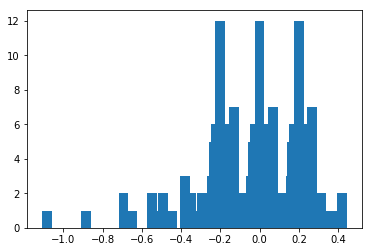

In [2]:
X_train,y_train = generate_data(train_samples,batch,Augment = False)
values, counts = np.unique(y_train,return_counts = True)

plt.bar(values, counts, width = 0.05)
plt.savefig('readme_files/incom.png')

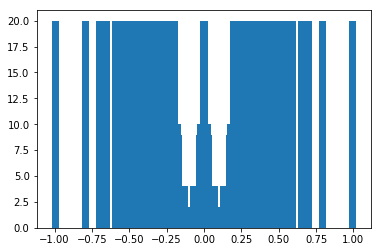

In [7]:
X_train,y_train = generate_data(train_samples,batch,Augment = True)
X_valid,y_valid = generate_data(valid_samples,batch,Augment = False)

values, counts = np.unique(y_train,return_counts = True)

plt.bar(values, counts, width = 0.05)

plt.savefig('readme_files/com.png')

In [8]:
with open('train2.p', 'wb') as f:
    pickle.dump([X_train, y_train], f)
    
with open('valid2.p','wb') as f:
    pickle.dump([X_valid,y_valid], f)

In [ ]:
img1 = '../Data/track1_1/IMG/center_2020_05_25_12_18_35_145.jpg'

img = cv2.imread(img1)
img = img[50:140,:,:]
img = cv2.resize(img,(200, 66), interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img = cv2.flip(img,1)
img = random_shadow(img)
print(img.dtype)
plt.imshow(img)

In [ ]:
img1 = '../Data/track1_1/IMG/center_2020_05_25_12_18_35_145.jpg'

img = cv2.imread(img1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img = random_shadow(img)
print(img.dtype)
plt.imshow(img)
print(img)

In [ ]:
img1 = '../Data/track1_1/IMG/center_2020_05_25_12_18_35_145.jpg'

img = cv2.imread(img1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img = random_translation(img)
print(img.dtype)
plt.imshow(img)
print(img)

uint8


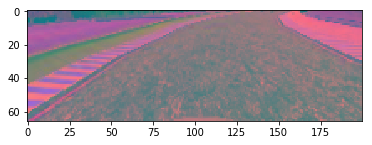

In [5]:
img2 = '../Data/track1_1/IMG/center_2020_05_25_12_18_35_145.jpg'

img = cv2.imread(img2)
img = img[65:140,:,:]
img = cv2.resize(img,(200, 66), interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img = cv2.flip(img,1)
print(img.dtype)
plt.imshow(img)
plt.savefig('readme_files/out.png')

## Image Data Generator

<BarContainer object of 327 artists>

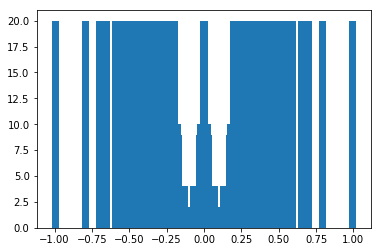

In [9]:
with open('train2.p','rb') as f:
    X_train, y_train = pickle.load(f)

with open('valid2.p','rb') as f:
    X_valid, y_valid = pickle.load(f)
    

values, counts = np.unique(y_train,return_counts = True)

plt.bar(values, counts, width = 0.05)

In [10]:
datagen = ImageDataGenerator()

In [11]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/gpu:0


## Self created model
used Nvidia deep learning architecture for self driving cars

In [12]:
### ----Deep-Learning Model 1 ----------------------------------------------------------------------------
model = Sequential()
#model.add(Lambda(lambda x:x/127.5 - 1.0,input_shape = (66,200,3)))
#model.add(Cropping2D(cropping = ((25,55),(0,0))))

model.add(BatchNormalization(trainable = False, input_shape=(66,200,3)))
model.add(Convolution2D(24,(5,5), kernel_regularizer = l2(0.001), strides = (2,2)))
model.add(ELU())
model.add(Convolution2D(36,(5,5), kernel_regularizer = l2(0.001), strides = (2,2)))
model.add(ELU())
model.add(Convolution2D(48,(5,5), kernel_regularizer = l2(0.001), strides = (2,2)))
model.add(ELU())
model.add(Convolution2D(64,(3,3), kernel_regularizer = l2(0.001)))
model.add(ELU())
model.add(Convolution2D(64,(3,3), kernel_regularizer = l2(0.001)))
model.add(ELU())

#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, kernel_regularizer = l2(0.001)))
model.add(ELU())
model.add(Dense(50, kernel_regularizer = l2(0.001)))
model.add(ELU())
model.add(Dense(10, kernel_regularizer = l2(0.001)))
model.add(ELU())
model.add(Dense(1))

In [13]:
model.compile(optimizer=Adam(lr = 1e-4),loss = 'mse')
#model.fit(X_train,y_train, epochs=4,validation_split = 0.2, shuffle = True)
model.fit_generator(datagen.flow(X_train,y_train, batch_size = batch, shuffle = True),
                    steps_per_epoch = math.ceil(len(train_samples)/batch), 
                    validation_data = (X_valid,y_valid), 
                    validation_steps = math.ceil(len(valid_samples)/batch), 
                    epochs = 20, verbose =1,
                    callbacks = [EarlyStopping(patience = 2)])
                   
#model.save('model3.h5') # Did not add random_brigthness for image augmentation ------best
#model.save('model4.h5')  # got closer trying to recreate model3
#model.save('model5.h5')  # very close but constantly swaying from side to side 
#model.save('model6.h5')  # trying to recreate model3 by resizing image to 66,200,3 ------ after resizing errors
#model.save('model7.h5')  # kernel_reg = l2(0.0001)
#model.save('model8.h5') #kernel_reg = l2(0.0001) and dropout 0.5 before flatten()
#model.save('model9.h5') #Works but jitters a lot no data 5
model.save('model10.h5') # no data 3 and 

Epoch 1/20
122/122 [==============================] - 15s 122ms/step - loss: 0.4749 - val_loss: 0.6539
Epoch 2/20
122/122 [==============================] - 13s 105ms/step - loss: 0.4301 - val_loss: 0.4848
Epoch 3/20
122/122 [==============================] - 13s 105ms/step - loss: 0.3973 - val_loss: 0.4245
Epoch 4/20
122/122 [==============================] - 13s 106ms/step - loss: 0.3638 - val_loss: 0.3855
Epoch 5/20
122/122 [==============================] - 13s 105ms/step - loss: 0.3309 - val_loss: 0.3522
Epoch 6/20
122/122 [==============================] - 13s 106ms/step - loss: 0.2995 - val_loss: 0.3208
Epoch 7/20
122/122 [==============================] - 13s 106ms/step - loss: 0.2699 - val_loss: 0.2913
Epoch 8/20
122/122 [==============================] - 13s 107ms/step - loss: 0.2425 - val_loss: 0.2644
Epoch 9/20
122/122 [==============================] - 13s 108ms/step - loss: 0.2172 - val_loss: 0.2403
Epoch 10/20
122/122 [==============================] - 13s 109ms/step - l

## ResNet152V2 Model
Used ResNet152V2 model for feature extraction and added 3 fully connected layers at the end of the model

In [ ]:
from keras_applications.resnet_common import ResNet152V2

resnet = ResNet152V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (66,200,3),
    backend = keras.backend,
    layers = keras.layers,
    models = keras.models,
    utils = keras.utils)

for layer in resnet.layers:
    layer.trainable = False
    
x = resnet.output

x = Flatten()(x)
x = Dense(1024, name="fc1" ,activation = 'relu', kernel_regularizer = l2(0.0001))(x)

x = Dense(256, name="fc2" ,activation = 'relu',kernel_regularizer = l2(0.0001))(x)

x = Dense(10, name="fc3" ,activation = 'relu',kernel_regularizer = l2(0.0001))(x)
predictions = Dense(1)(x)

ResNetModel = Model(inputs = resnet.input,outputs=predictions)

ResNetModel.summary()

In [ ]:
resbatch = 64

ResNetModel.compile(optimizer=Adam(lr = 0.0001),loss = 'mse')
#model.fit(X_train,y_train, epochs=4,validation_split = 0.2, shuffle = True)
ResNetModel.fit_generator(datagen.flow(X_train,y_train, batch_size = resbatch,shuffle = True),
                    steps_per_epoch = math.ceil(len(train_samples)/resbatch), 
                    validation_data = (X_valid,y_valid), 
                    validation_steps = math.ceil(len(valid_samples)/resbatch), 
                    epochs = 10, verbose =1)

ResNetModel.save('resnet_model1.h5')

## VGG16 Model

Used VGG16 model for feature extraction

In [ ]:
from keras_applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(weights='imagenet', 
    include_top=False,
    input_shape=[66, 200, 3],
    backend = keras.backend,
    layers = keras.layers,
    models = keras.models,
    utils = keras.utils)

for layer in vgg.layers:
        layer.trainable = False
        
x = vgg.output
x = Flatten()(x)

x = Dense(1024, activation='relu', name='fc1', kernel_regularizer=l2(0.001))(x)
x = Dense(256, activation='relu', name='fc2', kernel_regularizer=l2(0.001))(x)
predictions = Dense(1)(x)

VGG_model = Model(inputs =vgg.input , outputs = predictions)
VGG_model.summary()

In [ ]:
vggbatch = 64

VGG_model.compile(optimizer=Adam(lr = 0.0001),loss = 'mse')
#model.fit(X_train,y_train, epochs=4,validation_split = 0.2, shuffle = True)
VGG_model.fit_generator(datagen.flow(X_train,y_train, batch_size = vggbatch),
                    steps_per_epoch = math.ceil(len(train_samples)/vggbatch), 
                    validation_data = (X_valid,y_valid), 
                    validation_steps = math.ceil(len(valid_samples)/vggbatch), 
                    epochs = 20, verbose =1)

VGG_model.save('vgg_model1.h5')